In [1]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import math

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from madminer.ml.ensemble import Ensemble
from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator, HeteroskedasticScoreEstimator, RepulsiveEnsembleScoreEstimator

In [2]:
if not os.path.exists("data2"):
    os.makedirs("data2")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [4]:
z_std = 2.0
x_std = 1.0

def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc = theta[0] + theta[1], scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    t_xz = np.array([2*(z - theta[0] - theta[1]) / z_std**2, 2*(z - theta[0] - theta[1]) / z_std**2]).T

    return x, t_xz

def calculate_true_score(x, theta):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    t_x = np.array([2*(x - theta[0] - theta[1])/combined_std**2, 2*(x - theta[0] - theta[1])/combined_std**2])
    return t_x

def calculate_true_info(x, theta):
    score = calculate_true_score(x, theta)
    return np.einsum('jn,kn->njk', score, score)/len(x)

In [5]:
# number of parameter points to train
n_param_points = 1000

# numerator, uniform prior
theta0 = np.zeros(shape=(2,n_param_points))

# Sample from theta0
x_train, t_xz_train = simulate(theta0, theta0, theta0, theta0)

# Save to file
np.save("data2/x_train.npy", x_train)
np.save("data2/t_xz_train.npy", t_xz_train)

## Model training

In [127]:
# import cProfile

repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator(n_hidden=(20, 20), activation="relu")

# cProfile.run("""
repulsive_ensemble_sally.train(
    method="repulsive_ensemble_sally",
    x="data2/x_train.npy",
    t_xz="data2/t_xz_train.npy",
    n_epochs=1000,
    initial_lr=0.001,
    optimizer_kwargs={"weight_decay": 1.0 / (2 * n_param_points * 1.0**2)},
    scheduler=True
)
# """, "trainstats")
repulsive_ensemble_sally.save("models2/repulsive_ensemble_sally")

16:42 madminer.ml.score    INFO    Starting training
16:42 madminer.ml.score    INFO      Batch size:             128
16:42 madminer.ml.score    INFO      Optimizer:              amsgrad
16:42 madminer.ml.score    INFO      Epochs:                 1000
16:42 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:42 madminer.ml.score    INFO      Validation split:       0.25
16:42 madminer.ml.score    INFO      Early stopping:         True
16:42 madminer.ml.score    INFO      Scale inputs:           True
16:42 madminer.ml.score    INFO      Shuffle labels          False
16:42 madminer.ml.score    INFO      Samples:                all


16:42 madminer.ml.score    INFO    Loading training data
16:42 madminer.utils.vario INFO      Loading data2/x_train.npy into RAM
16:42 madminer.utils.vario INFO      Loading data2/t_xz_train.npy into RAM
16:42 madminer.ml.score    INFO    Found 1000 samples with 2 parameters and 1 observables
16:42 madminer.ml.base     INFO    Setting up input rescaling
16:42 madminer.ml.score    INFO    Creating model
16:42 madminer.ml.score    INFO    Training model
16:42 madminer.utils.ml.tr INFO    Training on CPU with single precision
16:42 madminer.utils.ml.tr INFO      Epoch  50: train loss -44.72663 (repulsive_ensemble_loss: -44.727)
16:42 madminer.utils.ml.tr INFO                 val. loss  -65.07101 (repulsive_ensemble_loss: -65.071)
16:42 madminer.utils.ml.tr INFO      Epoch 100: train loss -44.88999 (repulsive_ensemble_loss: -44.890)
16:42 madminer.utils.ml.tr INFO                 val. loss  -64.58955 (repulsive_ensemble_loss: -64.590)
16:42 madminer.utils.ml.tr INFO      Epoch 150: train l

In [51]:
sally = ScoreEstimator(n_hidden=(20, 20), activation="relu")

sally.train(
    method="sally",
    x="data2/x_train.npy",
    t_xz="data2/t_xz_train.npy",
    n_epochs=1000
)

sally.save("models2/sally")

13:32 madminer.ml.score    INFO    Starting training
13:32 madminer.ml.score    INFO      Batch size:             128
13:32 madminer.ml.score    INFO      Optimizer:              amsgrad
13:32 madminer.ml.score    INFO      Epochs:                 1000
13:32 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:32 madminer.ml.score    INFO      Validation split:       0.25
13:32 madminer.ml.score    INFO      Early stopping:         True
13:32 madminer.ml.score    INFO      Scale inputs:           True
13:32 madminer.ml.score    INFO      Shuffle labels          False
13:32 madminer.ml.score    INFO      Samples:                all
13:32 madminer.ml.score    INFO    Loading training data
13:32 madminer.utils.vario INFO      Loading data2/x_train.npy into RAM
13:32 madminer.utils.vario INFO      Loading data2/t_xz_train.npy into RAM
13:32 madminer.ml.score    INFO    Found 1000 samples with 2 parameters and 1 observables
13:32 madminer.ml.base    

In [52]:
n_estimators = 100
estimators = [
    ScoreEstimator(n_hidden=(20, 20), activation='relu') for i in range(n_estimators)
]
ensemble = Ensemble(estimators)
for i, _ in enumerate(estimators):
    ensemble.train_one(i,
        method="sally",
        x="data2/x_train.npy",
        t_xz="data2/t_xz_train.npy",
        n_epochs=100,
    )
    estimators[i].save(f"models/sally_{i}")

ensemble.save(f"models2/sally_ensemble")

13:32 madminer.ml.score    INFO    Starting training
13:32 madminer.ml.score    INFO      Batch size:             128
13:32 madminer.ml.score    INFO      Optimizer:              amsgrad
13:32 madminer.ml.score    INFO      Epochs:                 100
13:32 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:32 madminer.ml.score    INFO      Validation split:       0.25
13:32 madminer.ml.score    INFO      Early stopping:         True
13:32 madminer.ml.score    INFO      Scale inputs:           True
13:32 madminer.ml.score    INFO      Shuffle labels          False
13:32 madminer.ml.score    INFO      Samples:                all
13:32 madminer.ml.score    INFO    Loading training data
13:32 madminer.utils.vario INFO      Loading data2/x_train.npy into RAM
13:32 madminer.utils.vario INFO      Loading data2/t_xz_train.npy into RAM
13:32 madminer.ml.score    INFO    Found 1000 samples with 2 parameters and 1 observables
13:32 madminer.ml.base     

# Evaluation

In [6]:
n_param_points_test = 10000  # number of parameter points to test
theta_test = np.zeros(shape=(2,n_param_points))
x_test, _ = simulate(theta_test)
x_test = np.sort(x_test, axis=0)

np.save("data2/x_test.npy", x_test)

In [7]:
sally = ScoreEstimator()
sally.load("models2/sally")

t_hat_sally = sally.evaluate(
    theta=np.array([0,0]),
    x="data2/x_test.npy",
)
sally.calculate_fisher_information(x="data2/x_test.npy")

10:31 madminer.ml.base     INFO    Loading model from models2/sally
10:31 madminer.utils.vario INFO      Loading data2/x_test.npy into RAM


10:31 madminer.ml.base     INFO    Loading evaluation data
10:31 madminer.utils.vario INFO      Loading data2/x_test.npy into RAM
10:31 madminer.ml.base     INFO    Calculating Fisher information


array([[0.83779911, 0.83656491],
       [0.83656491, 0.83545665]])

In [8]:
repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator()
repulsive_ensemble_sally.load("models2/repulsive_ensemble_sally")

t_hat_repulsive_ensemble_sally, t_hat_sig_repulsive_ensemble_sally  = repulsive_ensemble_sally.evaluate(
    theta=np.array([0]),
    x="data2/x_test.npy",
)
info_repulsive_ensemble, info_cov_repulsive_ensemble = repulsive_ensemble_sally.calculate_fisher_information(x="data2/x_test.npy")

10:31 madminer.ml.base     INFO    Loading model from models2/repulsive_ensemble_sally


10:31 madminer.utils.vario INFO      Loading data2/x_test.npy into RAM
10:31 madminer.ml.score    INFO    Loading evaluation data
10:31 madminer.utils.vario INFO      Loading data2/x_test.npy into RAM
10:31 madminer.ml.score    INFO    Calculating Fisher information


In [57]:
sally_ensemble = Ensemble()
sally_ensemble.load("models2/sally_ensemble")

t_hat_sally_ensemble, _, t_hat_sig_sally_ensemble = sally_ensemble.evaluate_score(
    # theta=np.array([0]),
    theta=0,
    x="data2/x_test.npy",
    calculate_covariance=False,
    calculate_sigma=True
)
info_sally_ensemble, info_cov_sally_ensemble = sally_ensemble.calculate_fisher_information(x="data2/x_test.npy")

08:48 madminer.ml.ensemble INFO    Found score ensemble with 100 estimators
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_0
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_1
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_2
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_3
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_4
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_5
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_6
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_7
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_8
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_9
08:48 madminer.ml.base     INFO   

08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_13
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_14
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_15
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_16
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_17
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_18
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_19
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_20
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_21
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_22
08:48 madminer.ml.base     INFO    Loading model from models2/sally_ensemble/estimator_23
08:48 madm

In [70]:
infos_repulsive_ensemble, infos_cov_repulsive_ensemble = repulsive_ensemble_sally.calculate_fisher_information(x="data2/x_test.npy", sum_events=False)
infos_sally_ensemble, infos_cov_sally_ensemble = sally_ensemble.calculate_fisher_information(x="data2/x_test.npy", sum_events=False)
infos_true = calculate_true_info(x_test, [0,0])

08:52 madminer.ml.score    INFO    Loading evaluation data
08:52 madminer.utils.vario INFO      Loading data2/x_test.npy into RAM


08:52 madminer.ml.score    INFO    Calculating Fisher information
08:52 madminer.utils.vario INFO      Loading data2/x_test.npy into RAM


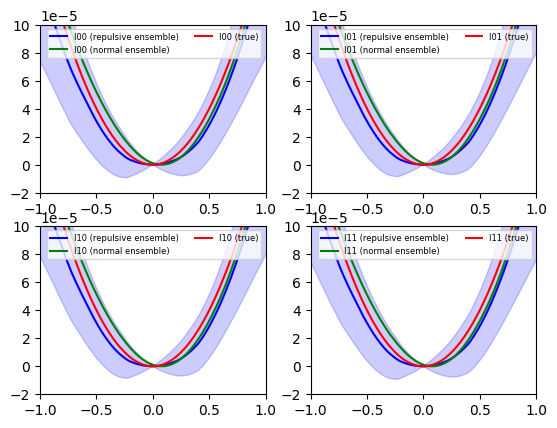

In [76]:
figs, axs = plt.subplots(2,2)

linestyles = ['-', '--', '-.', ':']
for i in range(2):
    for j in range(2):
        axs[i,j].plot(x_test, infos_repulsive_ensemble[:,i,j], label=f"I{i}{j} (repulsive ensemble)", ls='-', c='b')
        axs[i,j].fill_between(x_test, infos_repulsive_ensemble[:,i,j] + np.sqrt(np.einsum("nijkl->nil", infos_cov_repulsive_ensemble)[:,i,j]), infos_repulsive_ensemble[:,i,j] - np.sqrt(np.einsum("nijkl->nil", infos_cov_repulsive_ensemble)[:,i,j]), color='b', alpha=0.2)
        axs[i,j].plot(x_test, infos_sally_ensemble[:,i,j], label=f"I{i}{j} (normal ensemble)", ls='-', c='g')
        axs[i,j].plot(x_test, infos_true[:,i,j], label=f"I{i}{j} (true)", ls='-', c='r')
        axs[i,j].legend(ncol=2, fontsize=6)

        axs[i,j].set_xlim([-1,1])
        axs[i,j].set_ylim([-2e-5,1e-4])

plt.show()

In [61]:
def plot_contours(
    fisher_information_matrices,
    fisher_information_covariances=None,
    reference_thetas=None,
    contour_distance=2.4476,
    xlabel=r"$\theta_0$",
    ylabel=r"$\theta_1$",
    xrange=(-1.0, 1.0),
    yrange=(-1.0, 1.0),
    labels=None,
    inline_labels=None,
    resolution=500,
    colors=None,
    linestyles=None,
    linewidths=1.5,
    alphas=1.0,
    alphas_uncertainties=0.25,
    scale_x = 1.,
    scale_y = 1.,
    HARRY = None,
):
        
    # Input data
    fisher_information_matrices = np.asarray(fisher_information_matrices)

    n_matrices = fisher_information_matrices.shape[0]
    
    if HARRY is None:
        HARRY = n_matrices * [False]

    if fisher_information_matrices.shape != (n_matrices, 2, 2):
        raise RuntimeError(
            "Fisher information matrices have shape {}, not (n, 2,2)!".format(fisher_information_matrices.shape)
        )

    if fisher_information_covariances is None:
        fisher_information_covariances = [None for _ in range(n_matrices)]

    if reference_thetas is None:
        reference_thetas = [None for _ in range(n_matrices)]

    d2_threshold = contour_distance ** 2.0

    # Line formatting
    if colors is None:
        colors = ["C" + str(i) for i in range(10)] * (n_matrices // 10 + 1)
    elif not isinstance(colors, list):
        colors = [colors for _ in range(n_matrices)]

    if linestyles is None:
        linestyles = ["solid", "dashed", "dotted", "dashdot"] * (n_matrices // 4 + 1)
    elif not isinstance(linestyles, list):
        linestyles = [linestyles for _ in range(n_matrices)]

    if not isinstance(linewidths, list):
        linewidths = [linewidths for _ in range(n_matrices)]

    if not isinstance(alphas, list):
        alphas = [alphas for _ in range(n_matrices)]

    if not isinstance(alphas_uncertainties, list):
        alphas_uncertainties = [alphas_uncertainties for _ in range(n_matrices)]

    # Grid
    xi, yi, xx, yy, thetas = n_matrices * [None], n_matrices * [None], n_matrices * [None], n_matrices * [None], n_matrices * [None]
    print(len(HARRY), len(xi))
    for i, harry in enumerate(HARRY):
        if harry:
            xi[i] = np.linspace(np.sign(xrange[0])*xrange[0]**2, 
                                np.sign(xrange[1])*xrange[1]**2, resolution)
            yi[i] = np.linspace(np.sign(yrange[0])*yrange[0]**2, 
                                np.sign(yrange[1])*yrange[1]**2, resolution)
        else:
            xi[i] = np.linspace(xrange[0], xrange[1], resolution)
            yi[i] = np.linspace(yrange[0], yrange[1], resolution)
        xx[i], yy[i] = np.meshgrid(xi[i], yi[i], indexing="xy")
        xx[i], yy[i] = xx[i].flatten(), yy[i].flatten()
        thetas[i] = np.vstack((xx[i], yy[i])).T

    # Theta from reference thetas
    d_thetas = []
    for reference_theta, theta in zip(reference_thetas, thetas):
        if reference_theta is None:
            d_thetas.append(theta)
        else:
            d_thetas.append(theta - reference_theta)
    d_thetas = np.array(d_thetas)  # Shape (n_matrices, n_thetas, n_parameters)

    # Calculate Fisher distances
    fisher_distances_squared = np.einsum("mni,mij,mnj->mn", d_thetas, fisher_information_matrices, d_thetas)
    fisher_distances_squared = fisher_distances_squared.reshape((n_matrices, resolution, resolution))

    # Calculate uncertainties of Fisher distances
    fisher_distances_squared_uncertainties = []
    for d_theta, inf_cov in zip(d_thetas, fisher_information_covariances):
        if inf_cov is None:
            fisher_distances_squared_uncertainties.append(None)
            continue

        var = np.einsum("ni,nj,ijkl,nk,nl->n", d_theta, d_theta, inf_cov, d_theta, d_theta)

        uncertainties = (var ** 0.5).reshape((resolution, resolution))
        fisher_distances_squared_uncertainties.append(uncertainties)

#        logger.debug("Std: %s", uncertainties)

    # Plot results
    fig, ax = plt.subplots()
#    fig = plt.figure(figsize=(5.0, 5.0))

    # Error bands
    for i in range(n_matrices):
        if fisher_information_covariances[i] is not None:
            d2_up = fisher_distances_squared[i] + fisher_distances_squared_uncertainties[i]
            d2_down = fisher_distances_squared[i] - fisher_distances_squared_uncertainties[i]
            band = (d2_up > d2_threshold) * (d2_down < d2_threshold) + (d2_up < d2_threshold) * (d2_down > d2_threshold)

            if HARRY[i]:
                xi_plot = np.sqrt(np.abs(xi[i])) * np.sign(xi[i])
                yi_plot = np.sqrt(np.abs(yi[i])) * np.sign(yi[i])
            else:
                xi_plot = xi[i]
                yi_plot = yi[i]
            plt.contourf(xi_plot, yi_plot, band, [0.5, 2.5], colors=colors[i], alpha=alphas_uncertainties[i])

    # Predictions
    for i in range(n_matrices):
        if HARRY[i]:
            xi_plot = np.sqrt(np.abs(xi[i])) * np.sign(xi[i])
            yi_plot = np.sqrt(np.abs(yi[i])) * np.sign(yi[i])
        else:
            xi_plot = xi[i]
            yi_plot = yi[i]
        cs = ax.contour(
            xi_plot,
            yi_plot,
            fisher_distances_squared[i],
            np.array([d2_threshold]),
            colors=colors[i],
            linestyles=linestyles[i],
            linewidths=linewidths[i],
            alpha=alphas[i],
            # label=None if labels is None else labels[i],
        )

        if inline_labels is not None and inline_labels[i] is not None and len(inline_labels[i]) > 0:
            plt.clabel(cs, cs.levels, inline=True, fontsize=12, fmt={d2_threshold: inline_labels[i]})

    # Legend and decorations
    if labels is not None:
        ax.legend()

    # Scale the x and y axes by some factor
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax.yaxis.set_major_formatter(ticks_y)
    
    # Set Limits
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    # Set Labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    #ax.tight_layout()
    fig.subplots_adjust(left=0.18,bottom=0.16,top=0.94,right=0.96, hspace=0.0, wspace=0.0)

    return fig, ax

3 3


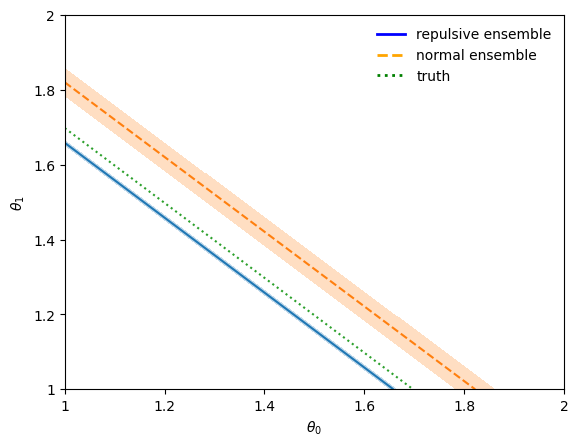

In [79]:
fig, ax = plot_contours(
    [info_repulsive_ensemble, info_sally_ensemble, infos_true.sum(axis=0)],
    [info_cov_repulsive_ensemble, info_cov_sally_ensemble, None],
    xrange=(1, 2.0), 
    yrange=(1, 2.0)
)
legend_elements = [ 
        Line2D([0],[0], color='b',      lw=2, ls='solid',  label=r'repulsive ensemble'),
        Line2D([0],[0], color='orange', lw=2, ls='dashed', label=r'normal ensemble'),
        Line2D([0],[0], color='green',  lw=2, ls='dotted', label=r'truth'),
    ]
plt.legend(handles=legend_elements, frameon=False)
plt.show()